In [2]:
import xarray as xr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,date
import os
import seaborn as sns
sns.set_style("darkgrid")


In [3]:
def add_date_dim(data):  # data: xarray dataset

    to_int = data.mcdate.astype('int')
    to_str = to_int.astype('str')
    dates_list = [datetime.strptime(date, '%Y%m%d')
                  for date in list(to_str.values)]
    data.coords["time"] = dates_list
    
    return data

In [4]:
var_list=["NH4_sorp","NH4_sorp_eq","NH4_sol","NO3","N_INSAPf","N_INSAPb","NH4sol_vert_change","N_nitrif_rate","Moisture","NO3_vert_change","N_INEcM","N_INAM","N_Leaching","N_Deposition","N_InPlant","N_SMIN"]
C_pool_names   =  ['LITm', 'LITs', 'SAPb', 'SAPf', 'EcM','AM', 'SOMp', 'SOMa', 'SOMc']
N_pool_names =  ['N_LITm', 'N_LITs', 'N_SAPb', 'N_SAPf', 'N_EcM', 'N_AM','N_SOMp', 'N_SOMa', 'N_SOMc', 'N_NH4_sol','N_NH4_sorp','N_NO3']
N_pool_names2 =  ['N_LITm', 'N_LITs', 'N_SAPb', 'N_SAPf', 'N_EcM', 'N_AM','N_SOMp', 'N_SOMa', 'N_SOMc', 'NH4_sol','NH4_sorp','NO3']
depth  = np.array([0.02, 0.04, 0.06, 0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14,2.39,4.676,7.635,11.140,15.115])


### Define and import data. NOTE: Resampled to monthly means

In [5]:
#COPY THIS TO NOTEBOOK, THE globals() THING DOES NOT WORK FROM HERE.
def import_decomp(dir_list,file_ext):
    site_data=[]
    decomp_names=[]
    dirs = dir_list
    path_of_the_directory = '/home/ecaas/paper_version/revised_simulations/'

    for folder in dirs:
        ext = (file_ext)
        for files in os.listdir(path_of_the_directory+"/"+folder):
            if files.endswith(ext):
                filename = os.fsdecode(files)
                print(filename)
                name = filename[:-len(ext)-1]
                if name[0:2] != 'NR':
                    name='NR'+name#+folder
                else:
                    name = name #+folder
                
                globals()[name+"_"+folder] = xr.load_dataset(path_of_the_directory+"/"+folder+"/"+filename)
                add_date_dim(globals()[name+"_"+folder])
                globals()[name+"_"+folder] =  globals()[name+"_"+folder].resample(time="MS",loffset=pd.Timedelta(15,"d")).mean()

                globals()[name+"_"+folder].attrs['site_name'] = name
                globals()[name+"_"+folder].attrs['run_name'] = folder

                decomp_names.append(name)
                site_data.append(globals()[name+"_"+folder])
            else:
                continue

        site_data =  sorted(site_data,key=lambda x: x.site_name)
        decomp_names = sorted(decomp_names)
        #decomp_names: list of name strings
        #site_data: list of xarrays
    return decomp_names,site_data


In [6]:
# #Only do this if you don't already have monthly files (this cell takes ~1hr to run): 

# Ndep_add = import_decomp(["Ndep_add"],"to2000.nc")
# #NB: Ndep_add = [names,data]
# Ndep_noadd = import_decomp(["Ndep_base"],"to2000.nc")
# #NB: Ndep_add = [names,data]

# #Convert the monthly mean xarrays to netcdf files, so we can read these instead of the original files (which are very slow..)
# for d in Ndep_noadd[1]:
#     d.to_netcdf("/home/ecaas/paper_version/revised_simulations/N_enrichment_monthly/noadd/"+d.site_name+".nc")

# for d in Ndep_add[1]:
#     d.to_netcdf("/home/ecaas/paper_version/revised_simulations/N_enrichment_monthly/addN/"+d.site_name+".nc")

In [7]:
path_of_the_directory = './N_enrichment_monthly/noadd/'
noadd_names=[]
noadd_data = []
for files in os.listdir(path_of_the_directory):
        filename = os.fsdecode(files)

        globals()[filename[:-13]] = xr.load_dataset(path_of_the_directory+filename)
        noadd_names.append(filename[:-13])
        noadd_data.append(globals()[filename[:-13]])

noadd_data =  sorted(noadd_data,key=lambda x: x.site_name)
noadd_names = sorted(noadd_names)


In [8]:
path_of_the_directory = './N_enrichment_monthly/addN/'
addN_names=[]
addN_data = []
for files in os.listdir(path_of_the_directory):
        filename = os.fsdecode(files)

        globals()[filename[:-20]] = xr.load_dataset(path_of_the_directory+filename)
        addN_names.append(filename[:-20])
        addN_data.append(globals()[filename[:-20]])
addN_data =  sorted(addN_data,key=lambda x: x.site_name)
addN_names = sorted(addN_names)


### returns response ratios in a dataframe for given pool or sum of pools, [row = time, col = site]:

In [9]:
def response_df(pool_name):
    df = pd.DataFrame()
    for i in range(len(addN_data)):
        #define control and treatment datasets:
        treatment = addN_data[i]
        control = noadd_data[i]
        site_name = treatment.site_name #Note: same for both treatment and control
        response = tot_timeseries(treatment,[pool_name],pool_name)/tot_timeseries(control,[pool_name],pool_name)
        df[site_name] = response.to_dataframe()
    return df



def response_df_list(pool_list,name):
    df = pd.DataFrame()
    for i in range(len(addN_data)):
        #define control and treatment datasets:
        treatment = addN_data[i]
        control = noadd_data[i]
        site_name = treatment.site_name #Note: same for both treatment and control
        response = tot_timeseries(treatment,pool_list,name)/tot_timeseries(control,pool_list,name)
        df[site_name] = response.to_dataframe()
    return df


In [10]:
def top32_timeseries(ds,pool_list,name):
    #subs up amount of carbon in the top four layers of the pools given in pool_list. 
    timeseries = 0
    for pool in pool_list:
        timeseries += (ds[pool][:,0:5]*depth[0:5]).sum("levsoi")
    timeseries = timeseries.rename(name)
    return timeseries

def deep_soil_timeseries(ds,pool_list,name):
    timeseries = 0
    for pool in pool_list:
        timeseries += (ds[pool][:,5:len(ds.levsoi)]*depth[5:len(ds.levsoi)]).sum("levsoi")
    timeseries = timeseries.rename(name)
    return timeseries

def tot_timeseries(ds,pool_list,name):
    timeseries = 0
    for pool in pool_list:
        timeseries += (ds[pool]*depth[0:len(ds.levsoi)]).sum("levsoi")
    timeseries = timeseries.rename(name)
    return timeseries

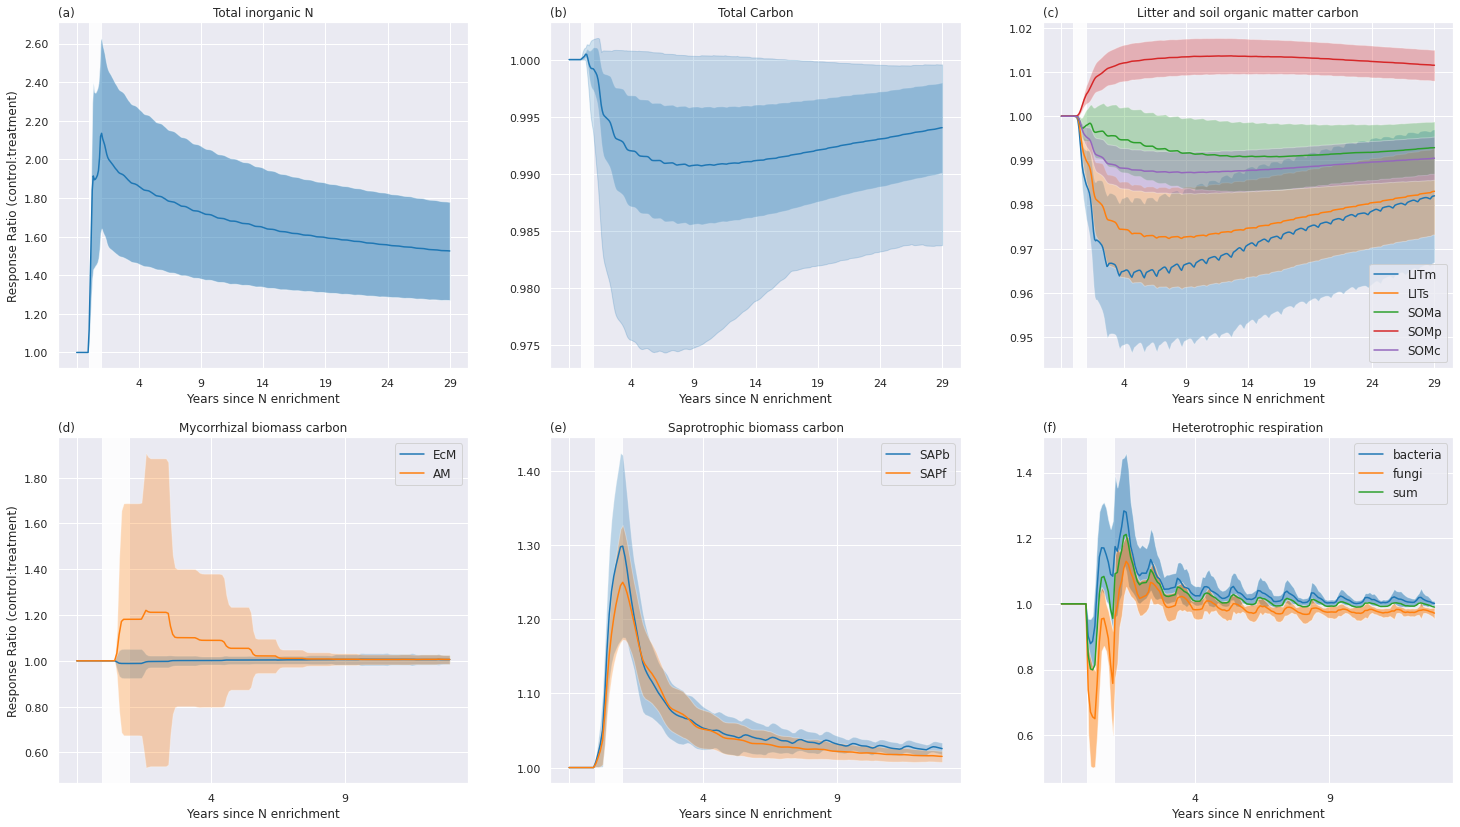

In [12]:

sns.set_context("notebook")

fig,ax = plt.subplots(nrows=2,ncols=3,figsize =[25,14])

var_df = response_df_list(["NO3","NH4_sol","NH4_sorp"],"test")#[0:12*14]
ax[0,0].plot(var_df.T.mean())
ax[0,0].fill_between(var_df.T.columns,var_df.T.mean()-var_df.T.std(),var_df.T.mean() + var_df.T.std(),alpha=0.5)
ax[0,0].set_title("(a)",fontsize=12,loc="left");
ax[0,0].set_title("Total inorganic N",fontsize=12,loc="center");#ax[0,0].legend(fontsize=12)
y1,y2=ax[0,0].get_ylim()
ax[0,0].fill_between(var_df.T.columns[11:24].shift(16, freq='D'),y1,y2,color="white",alpha =0.9,zorder=0)
ax[0,0].set_ylim(y1,y2);
ax[0,0].set_xticks(var_df.iloc[::12*5,:].index)
ax[0,0].set_xticklabels([" ","4","9","14","19","24","29"]);
ax[0,0].set_xlabel("Years since N enrichment",fontsize=12);
ax[0,0].set_ylabel("Response Ratio (control:treatment)",fontsize=12)

for name in ["EcM","AM"]:
    var_df = response_df(name)[0:12*14]
    ax[1,0].plot(var_df.T.mean(),label = name)
    ax[1,0].fill_between(var_df.T.columns,var_df.T.mean()-var_df.T.std(),var_df.T.mean() + var_df.T.std(),alpha=0.3)
    y1,y2=ax[1,0].get_ylim()
ax[1,0].fill_between(var_df.T.columns[11:24].shift(16, freq='D'),y1,y2,color="white",alpha =0.9,zorder=0)
ax[1,0].set_title("(d)",fontsize=12,loc="left");
ax[1,0].set_title("Mycorrhizal biomass carbon",fontsize=12, loc = "center");
ax[1,0].legend(fontsize=12)
ax[1,0].set_ylim(y1,y2);
ax[1,0].set_xticks(var_df.iloc[::12*5,:].index)
ax[1,0].set_xticklabels([" ","4","9"])
ax[1,0].set_xlabel("Years since N enrichment",fontsize=12)
ax[1,0].set_ylabel("Response Ratio (control:treatment)",fontsize=12)


for name in ["SAPb","SAPf"]:
    var_df = response_df(name)[0:12*14]
    ax[1,1].plot(var_df.T.mean(),label = name)
    ax[1,1].fill_between(var_df.T.columns,var_df.T.mean()-var_df.T.std(),var_df.T.mean() + var_df.T.std(),alpha=0.3)
    y1,y2=ax[1,1].get_ylim()
ax[1,1].fill_between(var_df.T.columns[11:24].shift(16, freq='D'),y1,y2,color="white",alpha =0.9,zorder=0)
ax[1,1].set_title("(e)",fontsize=12,loc="left");
ax[1,1].set_title("Saprotrophic biomass carbon",loc="center", fontsize=12);
ax[1,1].legend(fontsize=12)
ax[1,1].set_ylim(y1,y2);
ax[1,1].set_xticks(var_df.iloc[::12*5,:].index)
ax[1,1].set_xticklabels([" ","4","9"])
ax[1,1].set_xlabel("Years since N enrichment",fontsize=12)

for name in ["HR"]:
    var_df_b = response_df(name+"b")[0:12*14]
    var_df_f = response_df(name+"f")[0:12*14]
    ax[1,2].plot(var_df_b.T.mean(),label = "bacteria")
    ax[1,2].fill_between(var_df_b.T.columns,var_df_b.T.mean()-var_df_b.T.std(),var_df_b.T.mean() + var_df_b.T.std(),alpha=0.5)
    ax[1,2].plot(var_df_f.T.mean(),label = "fungi")
    ax[1,2].fill_between(var_df_f.T.columns,var_df_f.T.mean()-var_df_f.T.std(),var_df_f.T.mean() + var_df_f.T.std(),alpha=0.5)
    
    ax[1,2].set_title("(f)",fontsize=12,loc="left");
    ax[1,2].set_title("Heterotrophic respiration",fontsize=12,loc="center");
    ax[1,0].legend(fontsize=12)

ax[1,2].plot(response_df_list(["HRb","HRf"],"tot SAP HR").T.mean()[0:12*14],label = "sum")
ax[1,2].legend(fontsize=12)
y1,y2=ax[1,2].get_ylim()
ax[1,2].fill_between(var_df.T.columns[11:24].shift(16, freq='D'),y1,y2,color="white",alpha =0.9,zorder=0)
ax[1,2].set_ylim(y1,y2);
ax[1,2].set_xticks(var_df.iloc[::12*5,:].index)
ax[1,2].set_xticklabels([" ","4","9"])
ax[1,2].set_xlabel("Years since N enrichment",fontsize=12);

var_df = response_df_list(C_pool_names,"TOTC")
ax[0,1].plot(var_df.T.mean(),label = "TOTC")
ax[0,1].fill_between(var_df.T.columns,var_df.T.mean()-var_df.T.std(),var_df.T.mean() + var_df.T.std(),alpha=0.3)
ax[0,1].fill_between(var_df.T.columns,var_df.T.min(), var_df.T.max(),alpha=0.2,color="tab:blue")
y1,y2=ax[0,1].get_ylim()
ax[0,1].fill_between(var_df.T.columns[11:24].shift(16, freq='D'),y1,y2,color="white",alpha =0.9,zorder=0)
ax[0,1].set_title("(b)",fontsize=12,loc = "left");
ax[0,1].set_title("Total Carbon",fontsize=12,loc = "center");
#ax[0,1].legend(fontsize=12)
ax[0,1].set_ylim(y1,y2);
ax[0,1].set_xticks(var_df.iloc[::12*5,:].index)
ax[0,1].set_xticklabels([" ","4","9","14","19","24","29"]);
ax[0,1].set_xlabel("Years since N enrichment",fontsize=12)

for name in ["LITm","LITs","SOMa","SOMp","SOMc"]:
    var_df = response_df(name)
    ax[0,2].plot(var_df.T.mean(),label = name)
    ax[0,2].fill_between(var_df.T.columns,var_df.T.mean()-var_df.T.std(),var_df.T.mean() + var_df.T.std(),alpha=0.3)
    y1,y2=ax[0,2].get_ylim()
ax[0,2].fill_between(var_df.T.columns[11:24].shift(16, freq='D'),y1,y2,color="white",alpha =0.9,zorder=0)
ax[0,2].set_title("(c)",fontsize=12,loc="left");
ax[0,2].set_title("Litter and soil organic matter carbon",fontsize=12,loc="center");
ax[0,2].legend(fontsize=12)
ax[0,2].set_ylim(y1,y2);
ax[0,2].set_xticks(var_df.iloc[::12*5,:].index)
ax[0,2].set_xticklabels([" ","4","9","14","19","24","29"]);
ax[0,2].set_xlabel("Years since N enrichment",fontsize=12);

for row in range(2):
    for col in range(2):
        ax[row,col].yaxis.set_major_formatter('{x:.2f}')

ax[0,1].get_yaxis().set_major_formatter(plt.FormatStrFormatter(f'%.3f'))
#plt.savefig("./figures/N_enrich_%s.png"%str(date.today()),bbox_inches="tight",dpi=300)
plt.savefig("./Ndep.pdf",bbox_inches="tight")
